# Retinal OCT Classification with EfficientNet-V2

4-class classification of Optical Coherence Tomography (OCT) retinal images:
- **CNV**: Choroidal Neovascularization
- **DME**: Diabetic Macular Edema
- **DRUSEN**: Early Age-Related Macular Degeneration
- **NORMAL**: Healthy Retina

Dataset: [Retinal OCT Images](https://www.kaggle.com/datasets/paultimothymooney/kermany2018) (~84,000 images)

Architecture: EfficientNet-V2-S (consistent with brain tumor and pneumonia models)

## 1. Setup and Installation

In [1]:
!pip install -q kaggle

In [2]:
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm.auto import tqdm

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [3]:
# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

## 2. Download Dataset from Kaggle

In [4]:
# Upload your kaggle.json API key
from google.colab import files
print("Upload your kaggle.json file:")
uploaded = files.upload()

Upload your kaggle.json file:


Saving kaggle.json to kaggle.json


In [5]:
# Setup Kaggle credentials
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
# Download OCT dataset (5.81 GB - this may take a few minutes)
!kaggle datasets download -d paultimothymooney/kermany2018
!unzip -q kermany2018.zip -d data/
!rm kermany2018.zip

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/kermany2018
License(s): CC-BY-NC-SA-4.0
^C
unzip:  cannot find or open kermany2018.zip, kermany2018.zip.zip or kermany2018.zip.ZIP.
rm: cannot remove 'kermany2018.zip': No such file or directory


In [10]:
import kagglehub

path = kagglehub.dataset_download("paultimothymooney/kermany2018")

print("Path to dataset files:", path)

100%|██████████| 10.8G/10.8G [01:08<00:00, 171MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/kermany2018/versions/2


In [12]:
!ls "/root/.cache/kagglehub/datasets/paultimothymooney/kermany2018/versions/2"


 oct2017  'OCT2017 '


In [13]:
# Dataset paths - use the kagglehub cache location
DATA_ROOT = Path("/root/.cache/kagglehub/datasets/paultimothymooney/kermany2018/versions/2/OCT2017 ")
TRAIN_DIR = DATA_ROOT / "train"
VAL_DIR = DATA_ROOT / "val"
TEST_DIR = DATA_ROOT / "test"

# Verify structure
print("Classes:", sorted(os.listdir(TRAIN_DIR)))
print()
for split, path in [("Train", TRAIN_DIR), ("Val", VAL_DIR), ("Test", TEST_DIR)]:
    total = sum(len(os.listdir(path / c)) for c in os.listdir(path))
    print(f"{split}: {total:,} images")

Classes: ['CNV', 'DME', 'DRUSEN', 'NORMAL']

Train: 83,484 images
Val: 32 images
Test: 968 images


## 3. Explore Dataset

Training set class distribution:
  CNV: 37,205 images
  DME: 11,348 images
  DRUSEN: 8,616 images
  NORMAL: 26,315 images


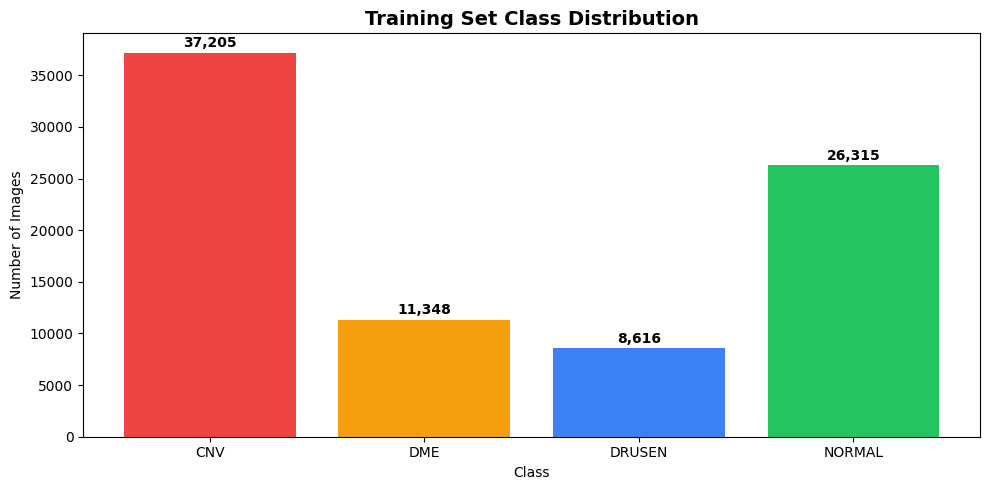

In [14]:
# Class distribution
class_counts = {}
for cls in sorted(os.listdir(TRAIN_DIR)):
    class_counts[cls] = len(os.listdir(TRAIN_DIR / cls))

print("Training set class distribution:")
for cls, count in class_counts.items():
    print(f"  {cls}: {count:,} images")

# Plot distribution
plt.figure(figsize=(10, 5))
classes = list(class_counts.keys())
counts = list(class_counts.values())
colors = ['#ef4444', '#f59e0b', '#3b82f6', '#22c55e']
bars = plt.bar(classes, counts, color=colors)
plt.title('Training Set Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Number of Images')
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500,
             f'{count:,}', ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150)
plt.show()

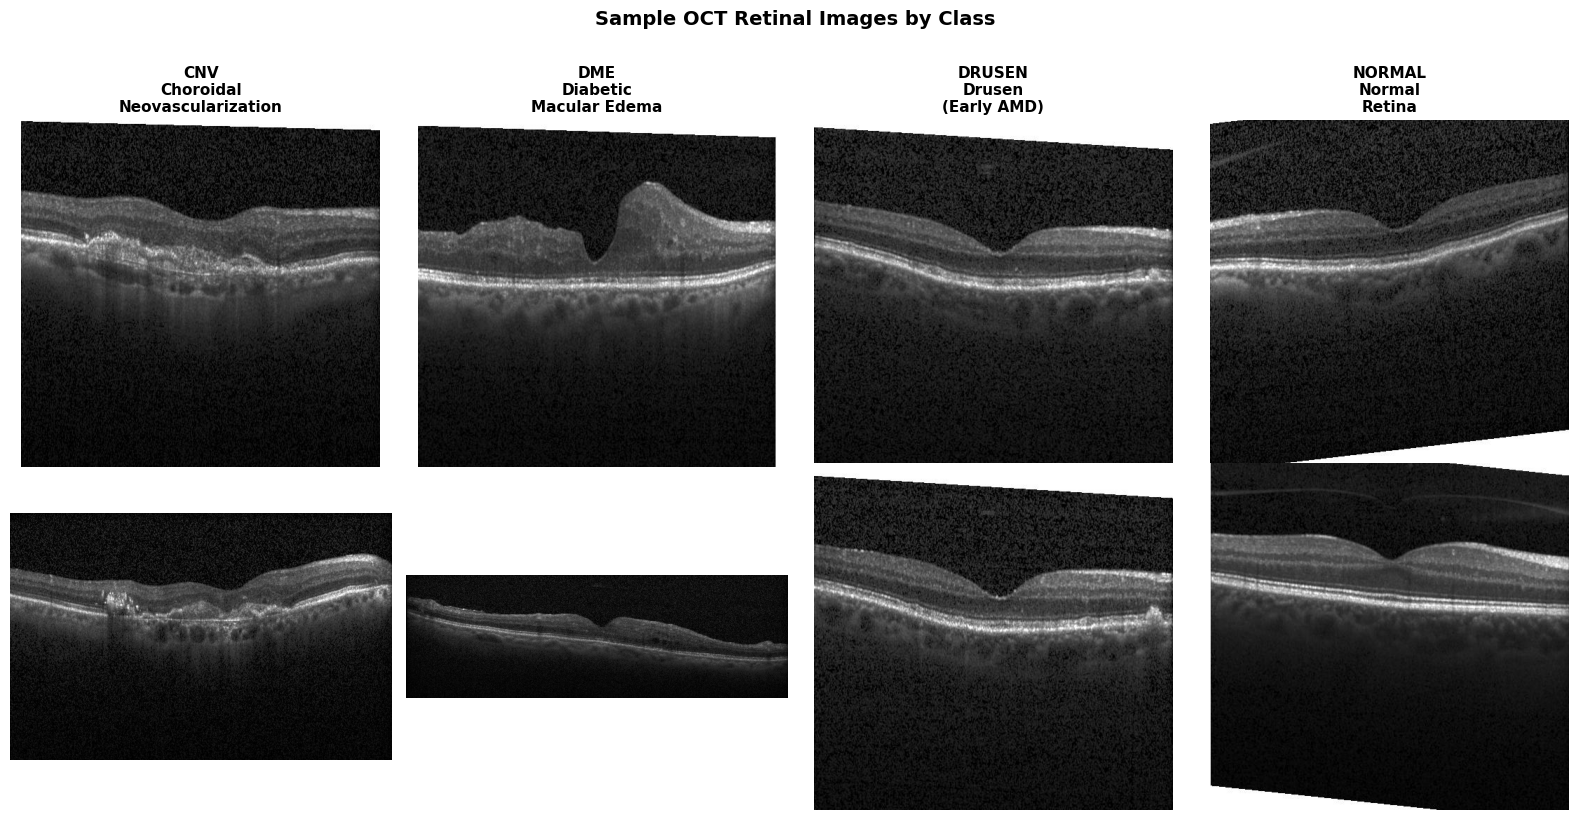

In [15]:
# Visualize sample images from each class
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
class_descriptions = [
    'Choroidal\nNeovascularization',
    'Diabetic\nMacular Edema',
    'Drusen\n(Early AMD)',
    'Normal\nRetina'
]

for idx, cls in enumerate(class_names):
    cls_path = TRAIN_DIR / cls
    images = sorted(cls_path.glob('*.jpeg'))[:2]

    for i, img_path in enumerate(images):
        img = Image.open(img_path)
        ax = axes[i, idx]
        ax.imshow(img, cmap='gray')
        if i == 0:
            ax.set_title(f"{cls}\n{class_descriptions[idx]}", fontsize=11, fontweight='bold')
        ax.axis('off')

plt.suptitle('Sample OCT Retinal Images by Class', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('sample_images.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Data Preparation

In [16]:
# Configuration
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2
NUM_CLASSES = 4
CLASS_NAMES = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

In [17]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [18]:
# Create datasets
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_transform)

print(f"Training samples: {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")
print(f"Test samples: {len(test_dataset):,}")
print(f"\nClass mapping: {train_dataset.class_to_idx}")

Training samples: 83,484
Validation samples: 32
Test samples: 968

Class mapping: {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


In [19]:
# Handle class imbalance with weighted sampling
targets = train_dataset.targets
class_counts_tensor = Counter(targets)
total_samples = len(targets)

# Calculate weights for each class
class_weights = {cls: total_samples / count for cls, count in class_counts_tensor.items()}
sample_weights = [class_weights[label] for label in targets]

# Create weighted sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

print("Class weights for balanced sampling:")
for cls_idx, cls_name in enumerate(CLASS_NAMES):
    print(f"  {cls_name}: {class_weights[cls_idx]:.3f}")

Class weights for balanced sampling:
  CNV: 2.244
  DME: 7.357
  DRUSEN: 9.689
  NORMAL: 3.172


In [20]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Training batches: {len(train_loader):,}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 2,609
Validation batches: 1
Test batches: 31


## 5. Model Architecture

In [21]:
def create_model(num_classes, pretrained=True):
    """Create EfficientNet-V2-S model with custom classifier."""
    # Load pretrained EfficientNet-V2-S
    weights = models.EfficientNet_V2_S_Weights.IMAGENET1K_V1 if pretrained else None
    model = models.efficientnet_v2_s(weights=weights)

    # Freeze early layers (keep last few trainable for fine-tuning)
    for param in list(model.parameters())[:-50]:
        param.requires_grad = False

    # Replace classifier head
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.15),
        nn.Linear(512, num_classes)
    )

    return model

# Create model
model = create_model(NUM_CLASSES)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 191MB/s]


Total parameters: 20,835,412
Trainable parameters: 4,497,156
Frozen parameters: 16,338,256


## 6. Training Setup

In [22]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-6)

# Training configuration
NUM_EPOCHS = 15
PATIENCE = 5  # Early stopping patience

In [23]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc="Training")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate(model, loader, criterion, device):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

## 7. Training Loop

In [24]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
patience_counter = 0

print(f"Training on {len(train_dataset):,} images for {NUM_EPOCHS} epochs...")
print(f"This will take approximately 2-3 hours on a T4 GPU.")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']:.2e}")

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Update scheduler
    scheduler.step()

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"✓ New best model saved! (Val Acc: {val_acc*100:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{PATIENCE}")

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs.")
        break

print("\n" + "=" * 60)
print(f"Training complete! Best validation accuracy: {best_val_acc*100:.2f}%")

Training on 83,484 images for 15 epochs...
This will take approximately 2-3 hours on a T4 GPU.

Epoch 1/15
Learning rate: 1.00e-04


Training:   0%|          | 0/2609 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.4706 | Train Acc: 82.15%
Val Loss: 0.1797 | Val Acc: 90.62%
✓ New best model saved! (Val Acc: 90.62%)

Epoch 2/15
Learning rate: 9.89e-05


Training:   0%|          | 0/2609 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92da980cc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92da980cc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92da980cc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
^^^^^^^^^^
AssertionError: can o

Train Loss: 0.3558 | Train Acc: 86.73%
Val Loss: 0.1695 | Val Acc: 93.75%


Exception ignored in: <function _ConnectionBase.__del__ at 0x7e9277659620>
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 133, in __del__
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


✓ New best model saved! (Val Acc: 93.75%)

Epoch 3/15
Learning rate: 9.57e-05


Training:   0%|          | 0/2609 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.3204 | Train Acc: 88.20%
Val Loss: 0.2236 | Val Acc: 90.62%
No improvement. Patience: 1/5

Epoch 4/15
Learning rate: 9.05e-05


Training:   0%|          | 0/2609 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92da980cc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92da980cc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.3050 | Train Acc: 88.74%
Val Loss: 0.1845 | Val Acc: 90.62%
No improvement. Patience: 2/5

Epoch 5/15
Learning rate: 8.36e-05


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92da980cc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()Exception ignored in: 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e92da980cc0>
    Traceback (most recent call last):
if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive():
 ^ ^ ^  ^ ^^  ^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^^    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^  ^  ^  
   File "/usr/lib

Training:   0%|          | 0/2609 [00:01<?, ?it/s]

 ^ ^  ^  ^ ^  ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^AssertionError: can only test a child process
Traceback (most recent call last):
^^  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
^  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
^  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
^OSError: [Errno 9] Bad file descriptor
^
AssertionError: can only test a child process
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.2890 | Train Acc: 89.36%
Val Loss: 0.1017 | Val Acc: 96.88%


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 259, in _feed
    reader_close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/lib/python3.12/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.12/multiprocessing/queues.py", line 291, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times


✓ New best model saved! (Val Acc: 96.88%)

Epoch 6/15
Learning rate: 7.52e-05


Training:   0%|          | 0/2609 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.2735 | Train Acc: 89.94%
Val Loss: 0.1632 | Val Acc: 96.88%
No improvement. Patience: 1/5

Epoch 7/15
Learning rate: 6.58e-05


Training:   0%|          | 0/2609 [00:00<?, ?it/s]

Validating:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.2604 | Train Acc: 90.43%
Val Loss: 0.1831 | Val Acc: 90.62%
No improvement. Patience: 2/5

Epoch 8/15
Learning rate: 5.57e-05


Training:   0%|          | 0/2609 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92da980cc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e92da980cc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

RuntimeError: DataLoader worker (pid(s) 29065) exited unexpectedly

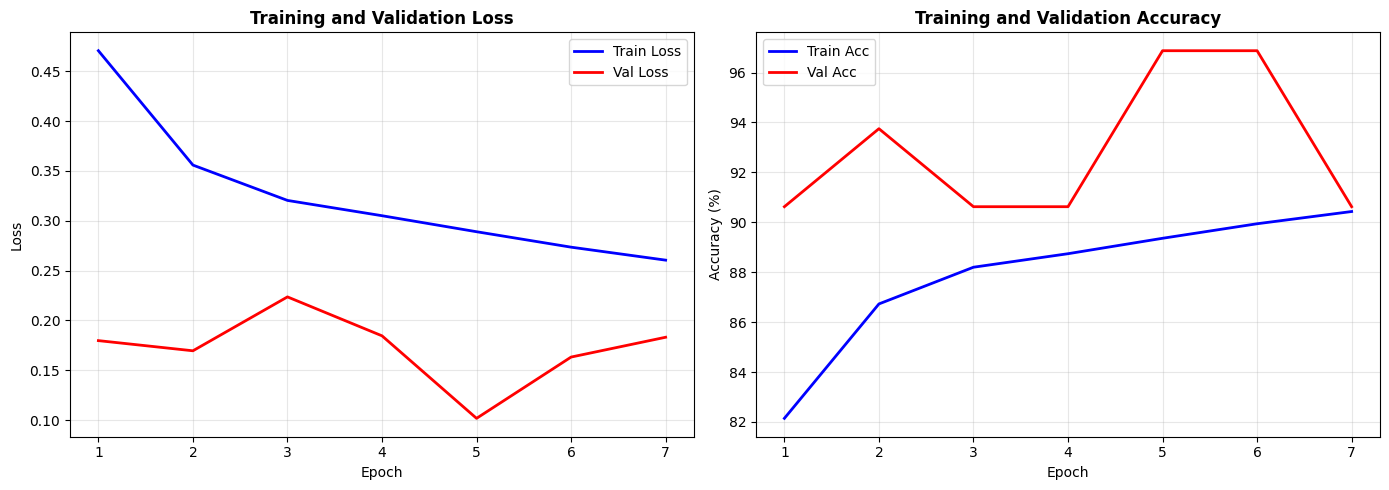

In [25]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss plot
ax1.plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax1.plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(epochs_range, [a*100 for a in history['train_acc']], 'b-', label='Train Acc', linewidth=2)
ax2.plot(epochs_range, [a*100 for a in history['val_acc']], 'r-', label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('retinal_oct_training.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Evaluation

In [26]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Evaluate on test set
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate accuracy
test_acc = (all_preds == all_labels).mean()
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

Testing:   0%|          | 0/31 [00:00<?, ?it/s]


Test Accuracy: 99.38%


In [27]:
# Classification report
print("\nClassification Report:")
print("=" * 60)
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES, digits=4))


Classification Report:
              precision    recall  f1-score   support

         CNV     0.9837    1.0000    0.9918       242
         DME     0.9959    0.9959    0.9959       242
      DRUSEN     1.0000    0.9835    0.9917       242
      NORMAL     0.9959    0.9959    0.9959       242

    accuracy                         0.9938       968
   macro avg     0.9939    0.9938    0.9938       968
weighted avg     0.9939    0.9938    0.9938       968



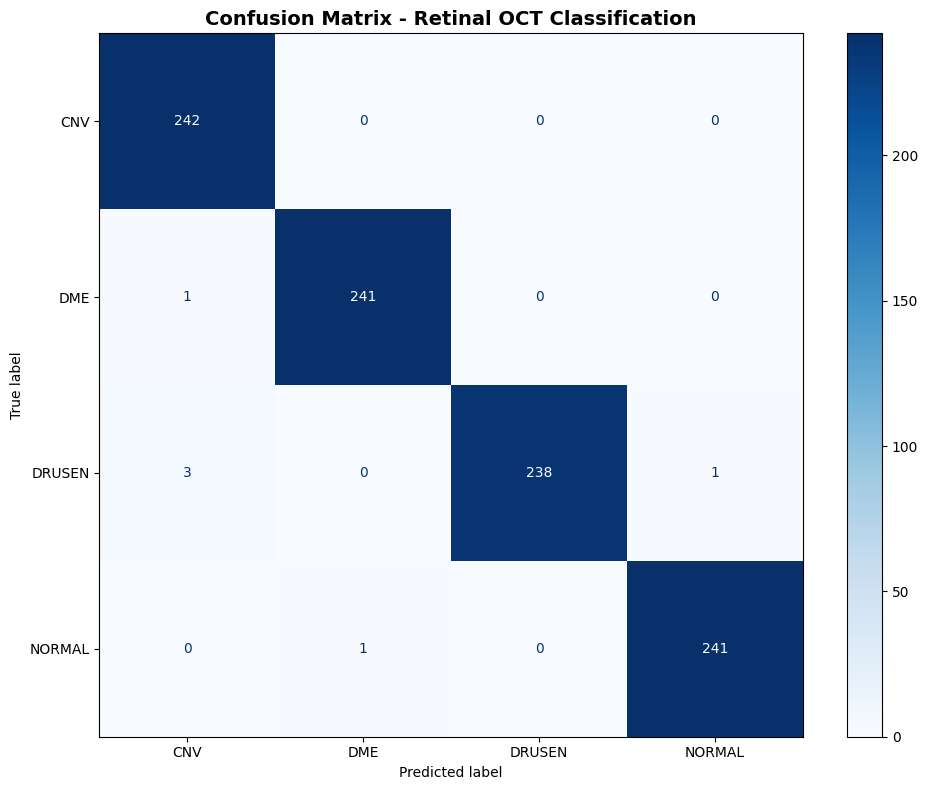


Per-class accuracy:
  CNV: 100.00%
  DME: 99.59%
  DRUSEN: 98.35%
  NORMAL: 99.59%


In [28]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Retinal OCT Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('retinal_oct_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Print per-class accuracy
print("\nPer-class accuracy:")
for i, cls in enumerate(CLASS_NAMES):
    cls_acc = cm[i, i] / cm[i].sum()
    print(f"  {cls}: {cls_acc*100:.2f}%")

## 9. Grad-CAM Visualization

In [29]:
import cv2

class GradCAM:
    """Grad-CAM visualization for EfficientNet."""

    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, target_class=None):
        self.model.eval()

        # Forward pass
        output = self.model(input_tensor)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Backward pass
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot)

        # Generate heatmap
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        # Resize to input size
        cam = torch.nn.functional.interpolate(
            cam, size=(224, 224), mode='bilinear', align_corners=False
        )

        return cam.squeeze().cpu().numpy(), target_class


def apply_colormap(heatmap, colormap=cv2.COLORMAP_JET):
    """Apply colormap to heatmap."""
    heatmap_uint8 = (heatmap * 255).astype(np.uint8)
    colored = cv2.applyColorMap(heatmap_uint8, colormap)
    return cv2.cvtColor(colored, cv2.COLOR_BGR2RGB)


def create_overlay(image, heatmap, alpha=0.5):
    """Overlay heatmap on image."""
    colored_heatmap = apply_colormap(heatmap)
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    overlay = (alpha * colored_heatmap + (1 - alpha) * image).astype(np.uint8)
    return overlay

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


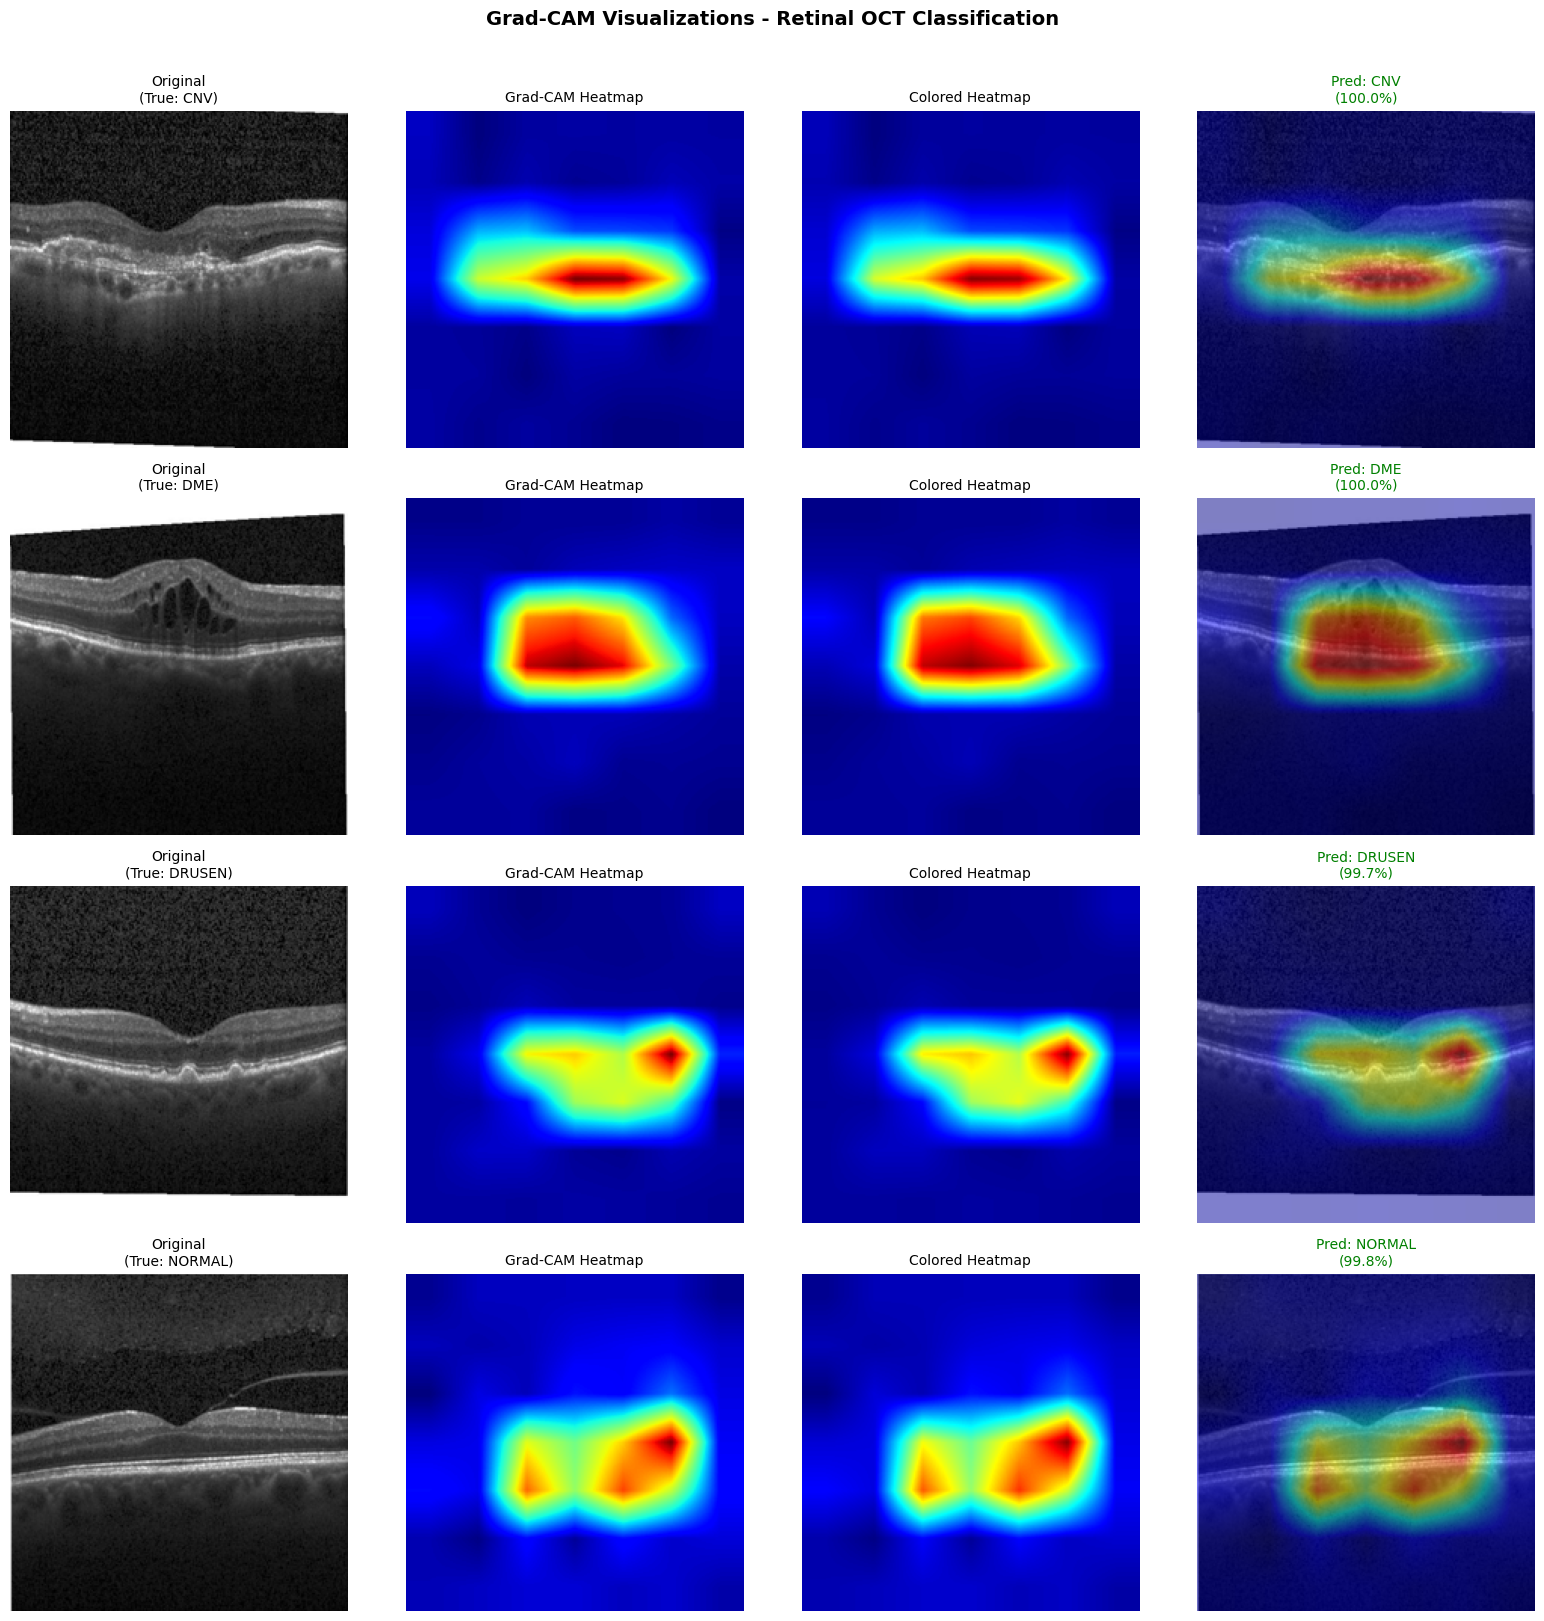

In [30]:
# Initialize Grad-CAM with the last convolutional layer
target_layer = model.features[-1]
gradcam = GradCAM(model, target_layer)

# Get sample images from each class in test set
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

for cls_idx, cls_name in enumerate(CLASS_NAMES):
    # Find an image from this class
    cls_path = TEST_DIR / cls_name
    img_path = sorted(cls_path.glob('*.jpeg'))[0]

    # Load and preprocess
    img = Image.open(img_path).convert('RGB')
    img_tensor = val_transform(img).unsqueeze(0).to(device)

    # Generate Grad-CAM
    heatmap, pred_class = gradcam.generate(img_tensor)

    # Get prediction probabilities
    with torch.no_grad():
        output = model(img_tensor)
        probs = torch.softmax(output, dim=1)[0]
        confidence = probs[pred_class].item()

    # Prepare images for display
    img_np = np.array(img.resize((224, 224)))
    colored_heatmap = apply_colormap(heatmap)
    overlay = create_overlay(img_np, heatmap, alpha=0.5)

    # Plot
    # Original
    axes[cls_idx, 0].imshow(img_np)
    axes[cls_idx, 0].set_title(f'Original\n(True: {cls_name})', fontsize=10)
    axes[cls_idx, 0].axis('off')

    # Heatmap
    axes[cls_idx, 1].imshow(heatmap, cmap='jet')
    axes[cls_idx, 1].set_title('Grad-CAM Heatmap', fontsize=10)
    axes[cls_idx, 1].axis('off')

    # Colored heatmap
    axes[cls_idx, 2].imshow(colored_heatmap)
    axes[cls_idx, 2].set_title('Colored Heatmap', fontsize=10)
    axes[cls_idx, 2].axis('off')

    # Overlay
    axes[cls_idx, 3].imshow(overlay)
    pred_name = CLASS_NAMES[pred_class]
    color = 'green' if pred_name == cls_name else 'red'
    axes[cls_idx, 3].set_title(f'Pred: {pred_name}\n({confidence*100:.1f}%)',
                                fontsize=10, color=color)
    axes[cls_idx, 3].axis('off')

plt.suptitle('Grad-CAM Visualizations - Retinal OCT Classification',
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('retinal_oct_gradcam.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. Export Model for Deployment

In [31]:
# Create deployment directory
!mkdir -p deployment

# Save model weights
model.load_state_dict(torch.load('best_model.pth'))
torch.save(model.state_dict(), 'deployment/retinal_oct_model.pth')

# Save model config
config = {
    'model_name': 'retinal_oct',
    'architecture': 'efficientnet_v2_s',
    'num_classes': NUM_CLASSES,
    'class_names': CLASS_NAMES,
    'input_size': IMG_SIZE,
    'normalize': {
        'mean': [0.485, 0.456, 0.406],
        'std': [0.229, 0.224, 0.225]
    },
    'test_accuracy': float(test_acc),
    'best_val_accuracy': float(best_val_acc)
}

with open('deployment/retinal_oct_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("Model config:")
print(json.dumps(config, indent=2))

Model config:
{
  "model_name": "retinal_oct",
  "architecture": "efficientnet_v2_s",
  "num_classes": 4,
  "class_names": [
    "CNV",
    "DME",
    "DRUSEN",
    "NORMAL"
  ],
  "input_size": 224,
  "normalize": {
    "mean": [
      0.485,
      0.456,
      0.406
    ],
    "std": [
      0.229,
      0.224,
      0.225
    ]
  },
  "test_accuracy": 0.993801652892562,
  "best_val_accuracy": 0.96875
}


In [32]:
# Copy visualization assets
!cp retinal_oct_training.png deployment/
!cp retinal_oct_confusion_matrix.png deployment/
!cp retinal_oct_gradcam.png deployment/

# Create deployment zip
!cd deployment && zip -r ../retinal_oct_deployment.zip .

print("\nDeployment package contents:")
!ls -la deployment/

  adding: retinal_oct_config.json (deflated 41%)
  adding: retinal_oct_model.pth (deflated 7%)
  adding: retinal_oct_confusion_matrix.png (deflated 23%)
  adding: retinal_oct_gradcam.png (deflated 1%)
  adding: retinal_oct_training.png (deflated 10%)

Deployment package contents:
total 84644
drwxr-xr-x 2 root root     4096 Jan 31 22:01 .
drwxr-xr-x 1 root root     4096 Jan 31 22:01 ..
-rw-r--r-- 1 root root      394 Jan 31 22:01 retinal_oct_config.json
-rw-r--r-- 1 root root    52443 Jan 31 22:01 retinal_oct_confusion_matrix.png
-rw-r--r-- 1 root root  2254366 Jan 31 22:01 retinal_oct_gradcam.png
-rw-r--r-- 1 root root 84249659 Jan 31 22:01 retinal_oct_model.pth
-rw-r--r-- 1 root root    95019 Jan 31 22:01 retinal_oct_training.png


In [33]:
# Download deployment package
from google.colab import files
files.download('retinal_oct_deployment.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Summary

### Results
- **Model**: EfficientNet-V2-S
- **Task**: 4-class Retinal OCT Classification
- **Classes**: CNV, DME, DRUSEN, NORMAL
- **Test Accuracy**: Check output above

### Deployment Files
- `retinal_oct_model.pth` - Model weights
- `retinal_oct_config.json` - Model configuration
- `retinal_oct_training.png` - Training curves
- `retinal_oct_confusion_matrix.png` - Confusion matrix
- `retinal_oct_gradcam.png` - Grad-CAM visualizations
